In [ ]:
# import modules
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupShuffleSplit
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import optimizers
from datetime import datetime
from kerastuner.tuners import RandomSearch


r_seed = 42

WORKDIR = 'C:/Users/thewr/git/LSTM_giroscopio_acelerometro.git/'
np.random.seed(r_seed)
tf.random.set_seed(r_seed)
data_hora= datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
LOG_DIR = WORKDIR + "/Code/DataPrep/"+data_hora

C:\Users\thewr\AppData\Local\Temp\ipykernel_28432\604600442.py:15: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [ ]:
date = datetime.now()
date = date.strftime("%d/%m/%Y_%H:%M")
arq = datetime.now()
arq = arq.strftime("%d_%m_%Y_%H_%M")

In [ ]:
## get dataset

# select only sensor data from smart watches
data = pd.read_csv('normalizado.csv')

In [ ]:
data.shape


(3368542, 9)

In [ ]:
data.head()

,pessoa_x,atividade,tempo,acelerômetro_x,acelerômetro_Y,acelerômetro_Z,giroscópio_x,giroscópio_Y,giroscópio_Z
0,1600,0,90426757696641,4.972757,-0.158317,6.696732,0.314944,-1.022277,-0.309962
1,1600,0,90426807196641,3.253720,-0.191835,6.107758,0.387382,-0.618541,-0.048972
2,1600,0,90426856696641,2.801216,-0.155922,5.997625,0.070999,-0.209480,-0.195978
3,1600,0,90426906196641,3.770868,-1.051354,7.731027,0.037975,0.254976,-0.156563
4,1600,0,90426955696641,4.661511,0.169689,9.684695,0.073129,0.719431,-0.001035


In [ ]:
data.isnull().sum()

pessoa_x          0
atividade         0
tempo             0
acelerômetro_x    0
acelerômetro_Y    0
acelerômetro_Z    0
giroscópio_x      0
giroscópio_Y      0
giroscópio_Z      0
dtype: int64

In [ ]:
#remove the null class
data=data.dropna()

# **Data Exploration**

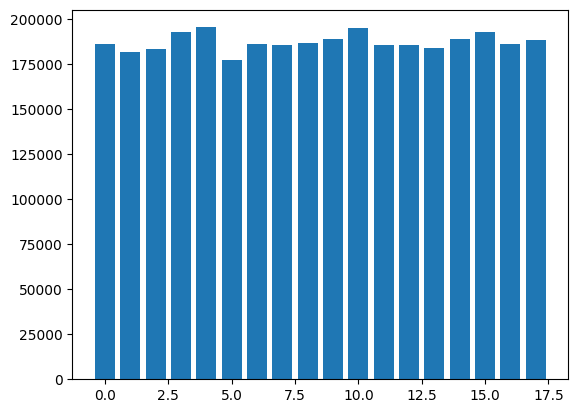

In [ ]:
## the distribution of output classes
plt.bar(data["atividade"].value_counts().index, data["atividade"].value_counts().values)
plt.show()

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

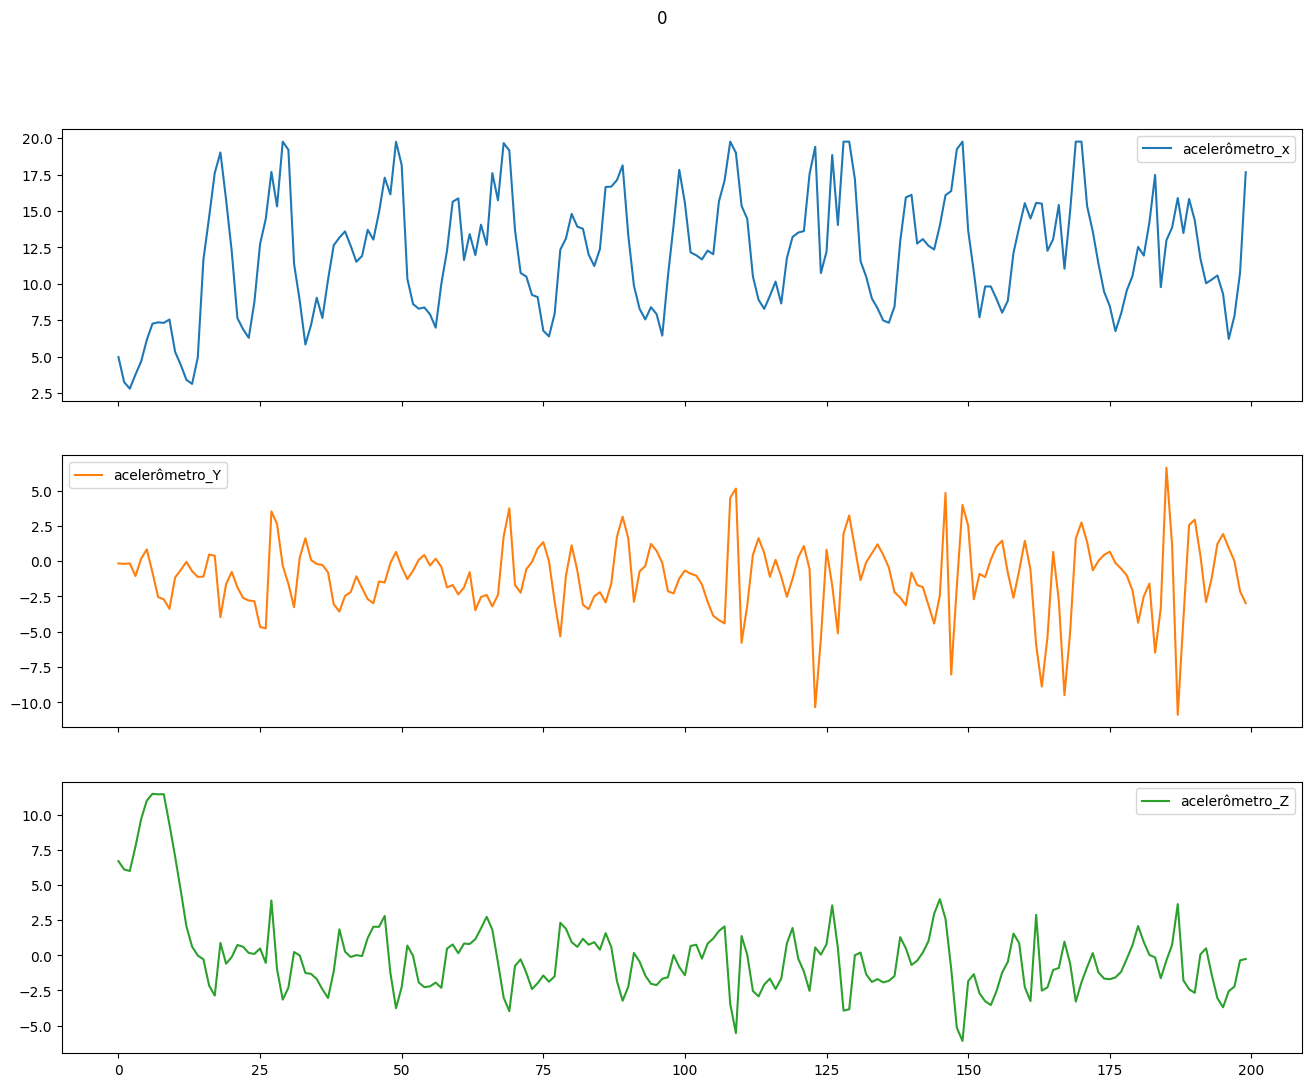

In [ ]:
## x,y,z vaues for activity 'sit'
data[(data['atividade'] == 0 )&(data['pessoa_x']==1600)][['acelerômetro_x','acelerômetro_Y','acelerômetro_Z']][:200].plot(title='0',subplots=True, figsize=(16, 12))

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

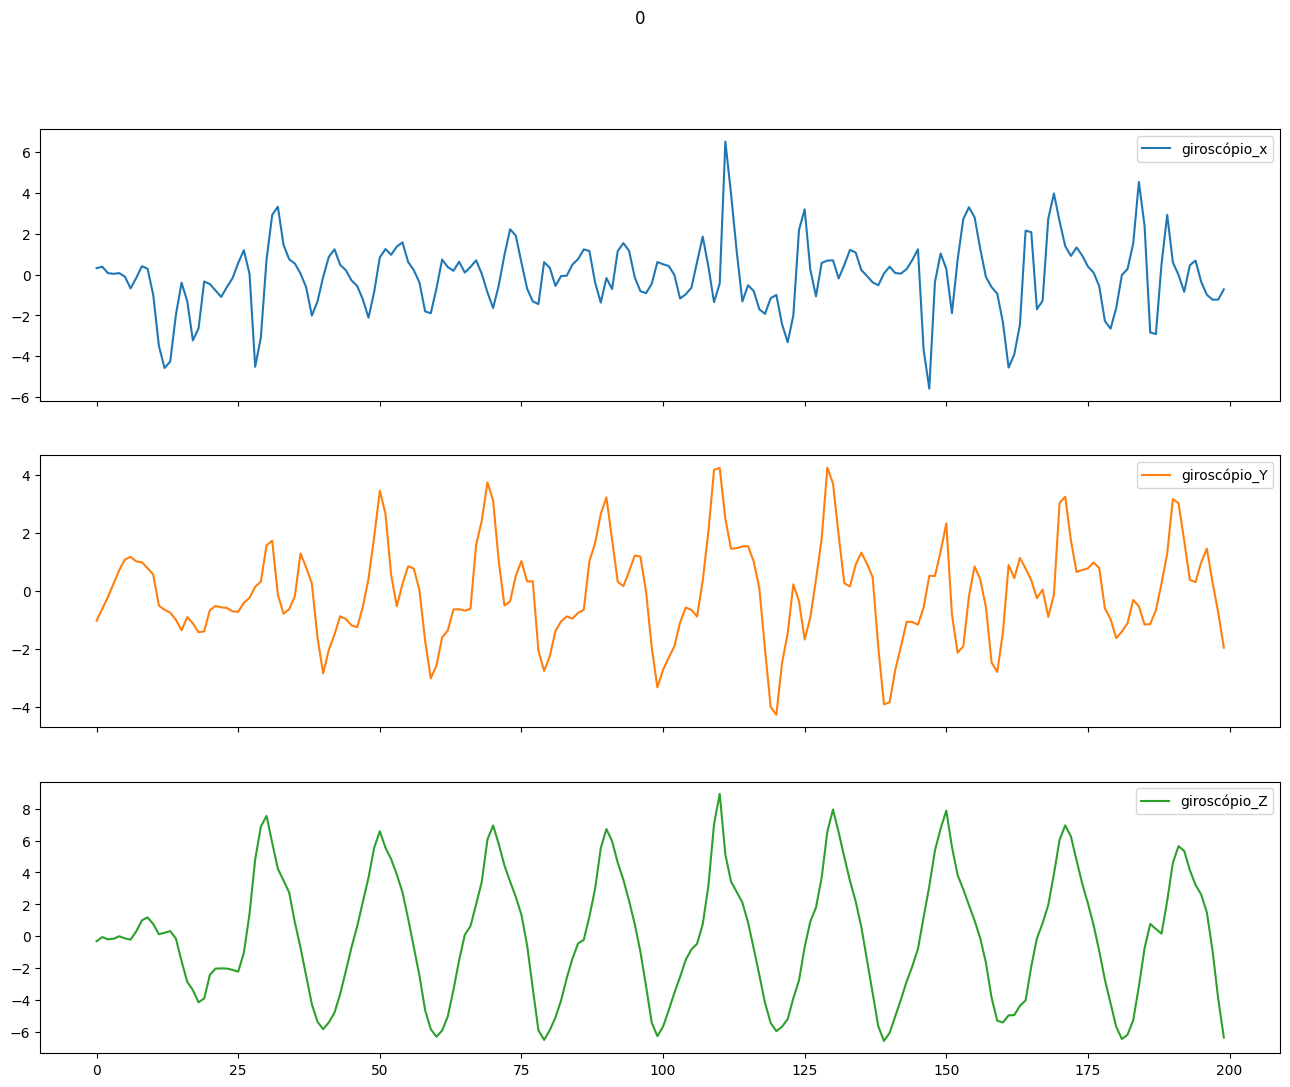

In [ ]:
## x,y,z vaues for activity 'stand'
data[(data['atividade'] == 0 )&(data['pessoa_x']==1600)][['giroscópio_x','giroscópio_Y','giroscópio_Z']][:200].plot(title='0',subplots=True, figsize=(16, 12))

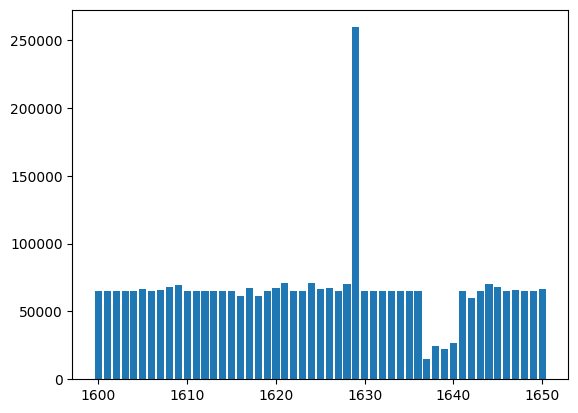

In [ ]:
## number of events per user

plt.bar(data["pessoa_x"].value_counts().index, data["pessoa_x"].value_counts().values)
plt.show()

In [ ]:
data = data[data["atividade"].isin([0,1,2,3])]

In [ ]:
data.shape

(743625, 9)

In [ ]:
data.head()

,pessoa_x,atividade,tempo,acelerômetro_x,acelerômetro_Y,acelerômetro_Z,giroscópio_x,giroscópio_Y,giroscópio_Z
0,1600,0,90426757696641,4.972757,-0.158317,6.696732,0.314944,-1.022277,-0.309962
1,1600,0,90426807196641,3.253720,-0.191835,6.107758,0.387382,-0.618541,-0.048972
2,1600,0,90426856696641,2.801216,-0.155922,5.997625,0.070999,-0.209480,-0.195978
3,1600,0,90426906196641,3.770868,-1.051354,7.731027,0.037975,0.254976,-0.156563
4,1600,0,90426955696641,4.661511,0.169689,9.684695,0.073129,0.719431,-0.001035


# **Models**

In [ ]:
X = data[['acelerômetro_x','acelerômetro_Y','acelerômetro_Z','giroscópio_x','giroscópio_Y','giroscópio_Z']]
y = data[['atividade']]





In [ ]:
X.head()

,acelerômetro_x,acelerômetro_Y,acelerômetro_Z,giroscópio_x,giroscópio_Y,giroscópio_Z
0,4.972757,-0.158317,6.696732,0.314944,-1.022277,-0.309962
1,3.253720,-0.191835,6.107758,0.387382,-0.618541,-0.048972
2,2.801216,-0.155922,5.997625,0.070999,-0.209480,-0.195978
3,3.770868,-1.051354,7.731027,0.037975,0.254976,-0.156563
4,4.661511,0.169689,9.684695,0.073129,0.719431,-0.001035


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=r_seed)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(594900, 6)
(594900, 1)
(148725, 6)
(148725, 1)


In [ ]:
def cria_IN_OUT(data, janela, features):
    OUT_indices = np.arange(janela, len(data), janela)
    #print("imprimindo out_indices")
    #print(OUT_indices)
    OUT = data[OUT_indices]
    #print("imprimindo out")
    #print(OUT)
    IN_indices = [range(i-janela, i) for i in OUT_indices]
    #print("imprimindo IN_INDICES")
    #print(IN_indices)
    #print("imprimindo IN_indices flattened")
    #print(np.array(IN_indices).flatten())
    IN = data[np.array(IN_indices).flatten()]
    #print("imprimindo IN")
    #print(IN)
    IN = np.reshape(IN, (len(OUT), janela, features))
    IN_final = IN[:, :, :]
    return IN_final

In [ ]:

featuresX = ['acelerômetro_x', 'acelerômetro_Y', 'acelerômetro_Z', 'giroscópio_x', 'giroscópio_Y', 'giroscópio_Z']
trainX = np.empty((0, 60, len(featuresX)), dtype=float)
testX = np.empty((0, 60, len(featuresX)), dtype=float)
trainY = np.empty((0, 60, 1), dtype=float)
testY = np.empty((0, 60, 1), dtype=float)

array_label_train = y_train.values
print("imprimindo label train length")
print(len(array_label_train))
print("imprimindo label train")
print(array_label_train)
array_label_test = y_test.values
print("imprimindo array label test length")
print(len(array_label_test))
arraytrain = X_train.values
print("imprimindo araytrain")
print(len(arraytrain))
arrayteste = X_test.values
print("imprimindo arraytest")
print(len(arrayteste))
transform = cria_IN_OUT(arraytrain, 60, 6)
transform2 = cria_IN_OUT(arrayteste, 60, 6)
transform3 = cria_IN_OUT(array_label_train, 60, 1)
transform4 = cria_IN_OUT(array_label_test, 60, 1)
trainX = np.concatenate([trainX, transform])
testX = np.concatenate([testX, transform2])
trainY = np.concatenate([trainY, transform3])
testY = np.concatenate([testY, transform4])
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)


imprimindo label train length
594900
imprimindo label train
[[1]
 [0]
 [0]
 ...
 [0]
 [0]
 [1]]
imprimindo array label test length
148725
imprimindo araytrain
594900
imprimindo arraytest
148725
(9914, 60, 6)
(9914, 60, 1)
(2478, 60, 6)
(2478, 60, 1)


In [ ]:
#optimizer = optimizers.Adam(clipvalue=1.0)

In [ ]:
def cria_LSTM(hp):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.LSTM(hp.Int("input_units",min_value=32,max_value=256,step=32), input_shape=(60,6),activation='tanh', return_sequences=True))
  #model.add(tf.keras.layers.Dense(units=64, activation=activation[0]))
  model.add(tf.keras.layers.Dropout(rate=hp.Float(
                'dropout_1',
                min_value=0.0,
                max_value=0.5,
                default=0.25,
                step=0.05,
            )))
  model.add(tf.keras.layers.BatchNormalization())
  #model.add(tf.keras.layers.Dense(units=32, activation=activation[0]))
  model.add(tf.keras.layers.Dense(units=4, activation='softmax'))
  model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(hp.Float(
                    'learning_rate',
                    min_value=1e-4,
                    max_value=1e-2,
                    sampling='LOG',
                    default=1e-3
                )), metrics=['accuracy'])
  return model


In [ ]:
tuner = RandomSearch(
    cria_LSTM,
    objective = 'val_accuracy',
    seed=42,
    max_trials = 20,
    executions_per_trial = 1,
    directory = LOG_DIR,
    project_name="lstm_multiclass_weighted")

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta = 0,
    verbose=1,
    restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=1,
    verbose=1)

tensorboard = tf.keras.callbacks.TensorBoard(LOG_DIR)

my_callbacks = [early_stopping,reduce_lr,tensorboard]

''' from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(tweets_for_model_training_target.sentimento),
                                                 tweets_for_model_training_target.sentimento)
class_weights = {i : class_weights[i] for i in range(0,3)} '''


" from sklearn.utils import class_weight\nclass_weights = class_weight.compute_class_weight('balanced',\n                                                 np.unique(tweets_for_model_training_target.sentimento),\n                                                 tweets_for_model_training_target.sentimento)\nclass_weights = {i : class_weights[i] for i in range(0,3)} "

In [ ]:
tuner.search(x=trainX,
            y=trainY,
            epochs=50,
            validation_data=(testX,testY), callbacks=my_callbacks,batch_size=60)

Trial 20 Complete [00h 14m 28s]
val_accuracy: 0.7663034796714783

Best val_accuracy So Far: 0.7694646120071411
Total elapsed time: 05h 08m 52s


In [ ]:
tuner.results_summary()

Results summary
Results in C:/Users/thewr/git/LSTM_giroscopio_acelerometro.git//Code/DataPrep/2023-11-27_11-40-46\lstm_multiclass_weighted
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 11 summary
Hyperparameters:
input_units: 128
dropout_1: 0.15000000000000002
learning_rate: 0.003964886305018653
Score: 0.7694646120071411

Trial 14 summary
Hyperparameters:
input_units: 192
dropout_1: 0.05
learning_rate: 0.0038287047044982298
Score: 0.7692157626152039

Trial 17 summary
Hyperparameters:
input_units: 256
dropout_1: 0.25
learning_rate: 0.0033137745378583987
Score: 0.7689332962036133

Trial 04 summary
Hyperparameters:
input_units: 256
dropout_1: 0.0
learning_rate: 0.008547485565344062
Score: 0.7684490084648132

Trial 06 summary
Hyperparameters:
input_units: 96
dropout_1: 0.2
learning_rate: 0.007177664122743156
Score: 0.7682808637619019

Trial 13 summary
Hyperparameters:
input_units: 160
dropout_1: 0.05
learning_rate: 0.0009824542588158123
Score: 0.767097115516

In [ ]:
tuner.get_best_hyperparameters()[0].values

{'input_units': 128,
 'dropout_1': 0.15000000000000002,
 'learning_rate': 0.003964886305018653}

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]

In [ ]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 128)           69120     
                                                                 
 dropout (Dropout)           (None, 60, 128)           0         
                                                                 
 batch_normalization (Batch  (None, 60, 128)           512       
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 60, 4)             516       
                                                                 
Total params: 70148 (274.02 KB)
Trainable params: 69892 (273.02 KB)
Non-trainable params: 256 (1.00 KB)
_________________________________________________________________


In [ ]:
loss, accuracy = best_model.evaluate(testX, testY)

78/78 [==============================] - 3s 27ms/step - loss: 0.5462 - accuracy: 0.7694


In [ ]:
predictions = best_model.predict(testX)

78/78 [==============================] - 2s 31ms/step


In [ ]:
print(testX)

[[[ 1.65214880e+00 -9.39873800e-01  9.64339500e+00 -2.13745310e-02
    1.02981780e-02 -2.57192120e-02]
  [-8.14306700e-01 -6.19831100e+00 -7.14194870e+00  0.00000000e+00
   -1.43810700e-01  8.30906260e-02]
  [ 1.76722020e-01  1.36514390e+00  1.07287170e+01 -2.16237470e+00
   -5.76032700e-01  1.40238870e+00]
  ...
  [ 1.57239200e+00  5.40341400e-01  5.54916100e+00  4.85835130e-01
    1.52454070e+00  1.30959620e+00]
  [ 6.07947700e+00 -5.40715500e+00  4.03767160e+00 -2.52702000e+00
    1.48381350e+00 -3.87545850e-01]
  [ 1.03404070e+01 -2.68270300e+00  2.21762930e-01 -2.92523400e+00
    3.20462970e-01 -9.23757600e-01]]

 [[ 4.56289960e+00 -8.09614300e+00 -3.15555790e+00  2.38592600e-02
    3.07834780e-03 -1.22180510e-02]
  [ 6.68206740e+00 -1.93595140e+01  4.50409200e-01 -4.42153000e+00
    2.75863650e+00 -3.17175360e+00]
  [ 1.22122240e+01 -2.08355400e+00  2.59067580e+00 -2.29701100e-01
   -1.59840270e-01 -7.30337560e-01]
  ...
  [ 6.08860450e+00 -1.93999180e+01  2.27643680e+00  1.33184

In [ ]:
print(testY)

[[[3.]
  [3.]
  [1.]
  ...
  [0.]
  [2.]
  [2.]]

 [[3.]
  [1.]
  [2.]
  ...
  [1.]
  [1.]
  [0.]]

 [[1.]
  [1.]
  [3.]
  ...
  [0.]
  [2.]
  [3.]]

 ...

 [[0.]
  [3.]
  [3.]
  ...
  [0.]
  [1.]
  [0.]]

 [[2.]
  [0.]
  [2.]
  ...
  [2.]
  [2.]
  [3.]]

 [[0.]
  [1.]
  [0.]
  ...
  [0.]
  [3.]
  [1.]]]


In [ ]:
print(predictions)

[[[2.34252913e-03 1.41689030e-03 8.83764029e-03 9.87402916e-01]
  [4.21176711e-03 1.76617730e-04 1.47608912e-03 9.94135499e-01]
  [2.68110394e-01 3.10685009e-01 3.39472264e-01 8.17323551e-02]
  ...
  [3.36180568e-01 1.35054991e-01 4.74855363e-01 5.39089851e-02]
  [2.84450799e-01 1.56972274e-01 4.82547522e-01 7.60293454e-02]
  [7.67733216e-01 2.54055788e-03 2.28821665e-01 9.04592162e-04]]

 [[3.70950140e-02 8.65060557e-03 2.62399744e-02 9.28014398e-01]
  [1.62011816e-03 9.85025227e-01 1.33097153e-02 4.50123152e-05]
  [5.70411801e-01 3.76842287e-03 4.23670262e-01 2.14946712e-03]
  ...
  [3.91505309e-04 9.98165309e-01 1.44103845e-03 2.14730130e-06]
  [6.55126199e-02 6.60405517e-01 2.65198797e-01 8.88310000e-03]
  [7.98055828e-01 1.21724606e-02 1.89459324e-01 3.12428223e-04]]

 [[6.89853877e-02 7.70313621e-01 1.58525690e-01 2.17530271e-03]
  [3.71611724e-03 9.55402851e-01 4.08808962e-02 1.04372404e-07]
  [4.52523818e-03 3.22143635e-04 3.59208439e-03 9.91560519e-01]
  ...
  [5.26624262e-01 

In [ ]:
classes_x=np.argmax(predictions,axis=2)

In [ ]:
print(classes_x)

[[3 3 2 ... 2 2 0]
 [3 1 0 ... 1 1 0]
 [1 1 3 ... 0 2 3]
 ...
 [0 3 3 ... 0 1 0]
 [0 0 2 ... 2 2 3]
 [0 1 2 ... 0 3 2]]


In [ ]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(testX, classes_x)

ValueError: Classification metrics can't handle a mix of unknown and multiclass-multioutput targets

In [ ]:
print(matrix)

In [ ]:
plot_confusion_matrix(cm= matrix,
                      normalize = False,
                      target_names = ['neutro', 'negativo', 'positivo'],
                      title        = "Confusion Matrix")

In [ ]:
print(metrics.classification_report(tweets_for_model_test_target.sentimento, predictions))

In [ ]:
best_model.save(WORKDIR+"/Model/best_models_saved/lstm_classification_multiclass_class_weight_tuned")

In [ ]:
historico = []
for i in range(10):
    reset_model()
    print('Rodada %d' % i)
    history = model.fit(trainX, trainY, epochs = 50, batch_size = 50, verbose = 1,  validation_data=(testX, testY))
    historico.append(history)


In [ ]:
plt.figure(figsize= (7,7))

plt.subplot(2,1,1)
plt.title("Loss - {}".format(data))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], 'k')
plt.legend(['treino', 'teste'])

plt.subplot(2,1,2)
plt.title("acurácia")
plt.ylim(0,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'], 'k')
plt.legend(['treino', 'teste'])
plt.xlabel('epoch')

In [ ]:
nome = 'Acurácia_{}'.format(data)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 7))
axes = axes.flatten()

for i in range(10):
    ax = axes[i]
    ax.set_title(f'Acurácia - Treino {i + 1}')
    ax.plot(historico[i].history['accuracy'], label='Treino')
    ax.plot(historico[i].history['val_accuracy'], label='Validação')
    ax.set_xlabel('Épocas')
    ax.set_ylabel('Acurácia')
    ax.set_ylim(0, 1)
    ax.legend()

plt.suptitle('Acurácia {}'.format(data))
plt.savefig('Plots/%s' % arq)
plt.tight_layout()

In [ ]:
## test set accuracy
model.evaluate(testX, testY)